# LAB4 - TensorFlow Lite
ver: 3

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl


## Wprowadzenie

Celem zajęć jest analiza działania konwersji sieci neuronowych do postaci możliwej do uruchomienia na urządzeniach o ograniczonych zasobach. W czasie zajęć będzie wykorzystywany zbiór Fashion MNIST, który zawiera 60000 obrazków w 10 kategoriach:

https://github.com/zalandoresearch/fashion-mnist


https://www.tensorflow.org/datasets/catalog/fashion_mnist


### Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning



In [ ]:
try:
  %tensorflow_version 2.x
except:
  pass

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D, MaxPooling2D

from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
import pathlib

import time

print(tf.__version__)

Przygotuj zbiór testowy. Zbiór fashion_mnist nie posiada słownych opisów klas.

In [ ]:
nb_classes = 10
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

Wypisz ilość elementów w zbiorze uczącym i testowym.





In [ ]:
print(X_test)
print(X_train)

print(len(list(X_test)))
print(len(list(X_train)))

**TODO** Zmień poniższy kod tak by wyświetlić 10 przykładowych obrazków - po jednym z każdej klasy.

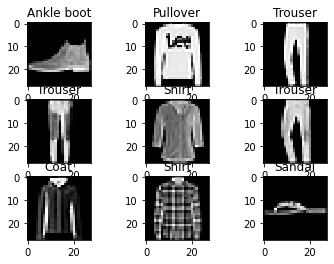

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i], cmap='gray', interpolation='none')
    plt.title("{}".format(class_names[y_test[i]]))

Sieć neuronowa przyjmuje na wejściu obrazek z jednym kanałem - poziomem jasności, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się macierzą 28 x 28 x 1. 

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [ ]:
X_train = X_train.reshape(60000, 28,28,1)
X_test = X_test.reshape(10000, 28,28,1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

print(nb_classes)

Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [ ]:
Y_train = np_utils.to_categorical(#TODO)
Y_test = np_utils.to_categorical(#TODO)

Wielowarstwowa sieć konwolucyjna do klasyfikacji ubrań.

In [ ]:
model = Sequential([
  Conv2D(16, 3, activation='relu', input_shape=(28, 28, 1)),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

W celu skrócenia czasu uczenia sieci wskazane jest użycie GPU.

In [ ]:
model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

# Zapisywanie NN

Szczegółowe informacje dotyczące zapisywania modeli TensorFlow dostępne pod linkiem:

https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
export_dir = 'saved_model'
model.save(export_dir)

Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". W katalogu "saved_model" znajduje się zapisany model.

# Export do TFLite

Narzędzie `TFLiteConverter` zostanie wykorzystane do konwersji modelu NN do formatu akceptowanego przez TFLite tzn. `flat protocol buffers`.

https://www.tensorflow.org/lite/guide/get_started#2_convert_the_model_format

Wygenerowany model `"model-base.tflite"` operuje na wagach typu `float32`.

In [ ]:
  converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
  tflite_model = converter.convert()

  with open("model-base.tflite", "wb") as f:
    f.write(tflite_model)  


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files". 

Kolejnym krokiem jest kwantyzacja wag modelu z 32 bitowych liczb rzeczywistych do liczb 8 bitowych. Proces kwantyzacji jest uruchamiany na gotowym, wyuczonym modelu. Należy wybrać profil optymaliacji `tf.lite.Optimize.DEFAULT`.



In [ ]:
  converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
  
  #TODO ustaw odpowiedni rodzaj optymalizacji sieci neuronowej

  tflite_model = converter.convert()

  with open("model-quant.tflite", "wb") as f:
    f.write(tflite_model)  


Po zapisaniu modelu należy kliknąć "Refresh" po lewej stronie w zakładce "Files".

In [ ]:
# funkcja testujaca model z wykorzystaniem interpretera TFLite
# TODO zmodyfikuj funkcje tak by zwracala (accuracy, latency)

def test_model_accuracy(tflite_model):
  # Load TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path=tflite_model)
  interpreter.allocate_tensors()

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  for img, label in zip(X_test, y_test):
    interpreter.set_tensor(input_index, [img])

    interpreter.invoke()

    prediction = interpreter.get_tensor(output_index)
    label_is = np.argmax(prediction, axis=-1)[0]
    label_should_be = label

    print("Label is {} should be {}.".format(label_is, label_should_be))

  return (0,0) #(accuracy, latency)


In [ ]:
#TODO tylko na potrzeby testowania - do usuniecia
print(test_model_accuracy("model-base.tflite"))

#TODO tylko na potrzeby testowania - do usuniecia
print(test_model_accuracy("model-quant.tflite"))


In [ ]:
# porównaj dokladnosc wynikowych modeli TFLite

# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)


In [ ]:
# porównaj rozmiar wynikowych modeli TFLite

# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)

In [ ]:
# porównaj czas dzialania wynikowych modeli TFLite

# TODO wyniki przedstaw na wykresie słupkowym (jeden slupek dla model-base, a drugi dla model-quant)

 # Wnioski

**TODO** przedstaw wnioski z przeprowadzonych eksperymentów
**TODO** dlaczego czasy działania modeli są różne?